In [1]:
import math
import joblib
import keras
import scipy

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
import h5py

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

The below class is a wrapper used to read and load data from matlab files.

In [2]:
class MatReader(object):
    def __init__(self, file_path, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_float(self, to_float):
        self.to_float = to_float

DATA LOADING AND PREPROCESSING

In [3]:
PATH = 'DeepONet_light.mat'
reader = MatReader(PATH)

r = 2 #downsampling factor, i.e. sample every second pixel in x and y
h = int(((101 - 1)/r) + 1) #downsampling to a coarser grid size
s = h #new resolution

n_total = 500 #total number of data samples 500 different coefficient fields and their solutions.
n_train = 250 #allocate half for training
n_test = n_total-n_train #allocate half for testing

x_read = np.array(reader.read_field('boundCoeff')[:,::r,::r][:,:s,:s])
#loads 500 samples of a 2d map (500,101,101), then it is downsampled to (500,51,51), then [:,:s,:s] extracts the top left 51x51 block for all 500 , redundant here but hey

y_read = np.array(reader.read_field('sol')[:,::r,::r][:,:s,:s])
#loads 500 samples of the corresponding sol, downsampling as explained above

#reshaping
# HF training data
x = x_read[:n_total].reshape((n_total, 1, s, s))  # X input (500,1,51,51) adding a dummy channel dimension why im not sure
y = y_read[:n_total].reshape((n_total, s, s, 1))  # HF output
x_train, y_train = x[:n_train, ...], y[:n_train, ...] #first 250 for testing last 250 for training
x_test, y_test = x[-n_test:, ...], y[-n_test:, ...]

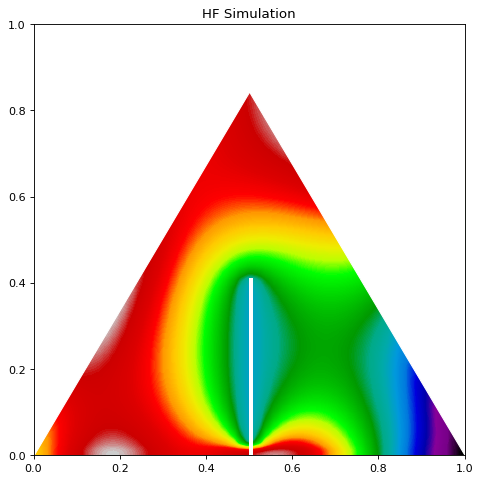

In [4]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 17

fig1 = plt.figure(figsize=(7,7), dpi=80)
plt.imshow(y_train[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral')
plt.title('HF Simulation')

xf = np.array([0., xmax/2]); yf = xf*(ymax/(xmax/2)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([xmax/2, xmax]); yf = (xf-xmax)*(ymax/((xmax/2)-xmax)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([0, xmax]); plt.fill_between(xf, ymax, s_disp, color = [1, 1, 1])
plt.gca().add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))

building coordinate grids for the spatial domain that correspond to the input data points used in training and testing. These grids will help map (x, y) spatial locations to the model inputs or outputs.

In [5]:
# x space
xspace = np.linspace(0,1,51,endpoint=False) #define a 1d co=ordinate array
gridspace = np.meshgrid(xspace,xspace) #takes two one d arrays and makes 2 2d arrays
x_grid = gridspace[0].reshape(51**2,1) # one 51X51 gridspace for x , reshaped into a long list of 51^2 or (2601,1)
y_grid = gridspace[1].reshape(51**2,1) # one 51X51 grid space for y, reshaped into a long list of 51^2

x1_grid_train = np.tile(x_grid,(n_train,1,1)) # now each training sample needs to get a grid of its own, i.e. we tile/repeat the array for each of the different darcy flow scenarios
#shape of above is now (n_train, 2601, 1)
x2_grid_train = np.tile(y_grid,(n_train,1,1)) ## as above but for the corresponding sol
x1_grid_test = np.tile(x_grid,(n_test,1,1)) #as above but for test samples
x2_grid_test = np.tile(y_grid,(n_test,1,1)) # as above but for test sol

#note when concatenating below we add y before x?
x_grid_train = np.concatenate([x2_grid_train,x1_grid_train], axis=-1) # add the arrays for both x and y (training samples) this gives us stacked grids of the following dim (n_train, 2601,2)
x_grid_test = np.concatenate([x2_grid_test,x1_grid_test], axis=-1) # as above but for test samples

In [6]:
x_train = x_train.reshape((n_train,1,51**2)) # reshaping the acc data now to match our model i.e. flattening the x data points from 51*51 for each darcy scenario to a flat line of 2601 for each scenario
y_train = y_train.reshape((n_train,51**2,1)) # as above but for solutions

In [7]:
print(f"Input field shape: {x_train.shape}")
print(f"Output field shape: {y_train.shape}")
print(f"Position field shape: {x_grid_train.shape}")
#now our data and grid points are properly preprocessed

Input field shape: (250, 1, 2601)
Output field shape: (250, 2601, 1)
Position field shape: (250, 2601, 2)


Building a model

In [8]:
def build_mlp(inputs, output_features: int,
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an MLP regression model.

    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.

    Returns:
        array: keras tensor.
    """
    x = inputs

    # Create hidden layers with tanh activation
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation='leaky_relu')(x)

    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features, activation='linear')(x)

    return outputs

In [9]:
def deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size this is not the sol of the data points it is the grids size
        u_in_size (tuple): function input size this is the SIZE of the inputs the concat xygrid
        trunk_params (dict): trunk net parameters dict decsribing the layers and params in each layer ect
        branch_params (dict): branch net parameters dict decsribing the layers and params in each layer ect
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size) #where do i want to know the value of the solution
    u_input = layers.Input(u_in_size) #this is the function input

    # Trunk layer
    trunk_out = build_mlp(y_input, trunk_params["output_features"],
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"])

    # Branch layer
    branch_out = build_mlp(u_input, branch_params["output_features"],
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

    # Multiply trunk and branch
    mult_out = layers.Multiply()([branch_out, trunk_out]) #weights times basis represenatation

    out = layers.Dense(out_feat,use_bias=False)(mult_out)

    model = Model(inputs=[y_input, u_input], outputs=out, name="DeepONet")

    return model


          u_input (function)      y_input (location)
               │                       │
       [Branch MLP]            [Trunk MLP]
               │                       │
         branch_out               trunk_out
               └─────┬──────┬──────┘
                     │ element-wise multiply
               mult_out = b_i(u) * φ_i(y)
                     │
            Dense layer (linear sum)
                     ↓
              Predicted u(y)


In [10]:
trunk_params=dict()
trunk_params["output_features"] = 128
trunk_params["hidden_features"] = 128
trunk_params["num_hidden_layers"] = 2

branch_params=dict()
branch_params["output_features"] = 128
branch_params["hidden_features"] = 128
branch_params["num_hidden_layers"] = 1

In [11]:
onet = deeponet(y_in_size=(51**2,2), u_in_size=(1,51**2), trunk_params=trunk_params,
                branch_params=branch_params, out_feat=1)
onet.summary()

Model: "DeepONet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2601, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1, 2601)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2601, 128) │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 128)    │    333,056 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2601, 128) │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 128)    │     16,512 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2601, 128) │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 2601, 128) │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2601, 1)   │        128 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 383,104 (1.46 MB)

 Trainable params: 383,104 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def scheduler(epoch):
    if epoch < 2000:
        lr = 0.001
    elif epoch < 10000:
        lr = 0.0005
    else:
        lr = 0.0001

    return lr

In [14]:
callback = keras.callbacks.LearningRateScheduler(scheduler)

onet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=["mse"]
)

Training phase



In [ ]:
history = onet.fit(x=[x_grid_train,x_train], y=y_train, batch_size=256, epochs=5000, callbacks=[callback], verbose=1)

Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.7138 - mse: 0.7138 - learning_rate: 0.0010
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4077 - mse: 0.4077 - learning_rate: 0.0010
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3598 - mse: 0.3598 - learning_rate: 0.0010
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2828 - mse: 0.2828 - learning_rate: 0.0010
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2882 - mse: 0.2882 - learning_rate: 0.0010
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2560 - mse: 0.2560 - learning_rate: 0.0010
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2625 - mse: 0.2625 - learning_rate: 0.0010
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2549 - mse: 0.2549 - learning_rate: 0.0010
Epoch 9/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2262 - mse: 0.2262 - learning_rate: 0.0010
Epoch 10/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2143 - mse: 0.2143 - l

In [ ]:
x_test.shape

(250, 1, 51, 51)

In [ ]:
x_test = x_test.reshape((n_test,1,51**2))

In [ ]:
preds = onet.predict([x_grid_test, x_test])

8/8 [==============================] - 1s 38ms/step


In [ ]:
y_test.shape

(250, 51, 51, 1)

In [ ]:
preds = preds.reshape((n_test,51,51,1))

In [ ]:
abs_error = np.abs(y_test-preds)

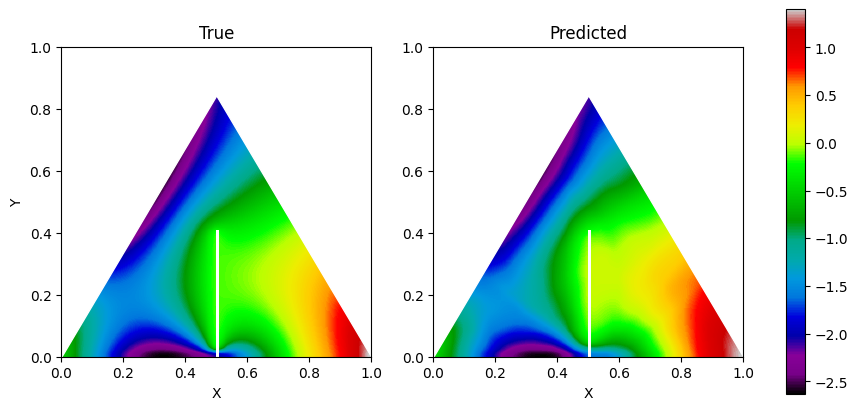

RMSE overall = 0.027559006586670876


In [ ]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 7

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
# Interpolated LF
im = ax[0].imshow(y_test[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  )
ax[0].set_title('True')

xf1 = np.array([0., xmax/2])
yf1 = xf1*(ymax/(xmax/2))
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([xmax/2, xmax])
yf1 = (xf1-xmax)*(ymax/((xmax/2)-xmax))
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([0, xmax])
ax[0].fill_between(xf1, ymax, s_disp, color = [1, 1, 1])
ax[0].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

# HF
im = ax[1].imshow(preds[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  )
ax[1].set_title('Predicted')

xf2 = np.array([0., xmax/2])
yf2 = xf2*(ymax/(xmax/2))
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([xmax/2, xmax])
yf2 = (xf2-xmax)*(ymax/((xmax/2)-xmax))
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([0, xmax])
ax[1].fill_between(xf2, ymax, s_disp, color = [1, 1, 1])
ax[1].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[1].set_xlabel("X")
# ax[1].set_ylabel("Y")

fig.colorbar(im, ax=ax.ravel().tolist())

rmse = np.sqrt(np.mean((y_test - preds)**2))

plt.show()

print(f"RMSE overall = {rmse}")


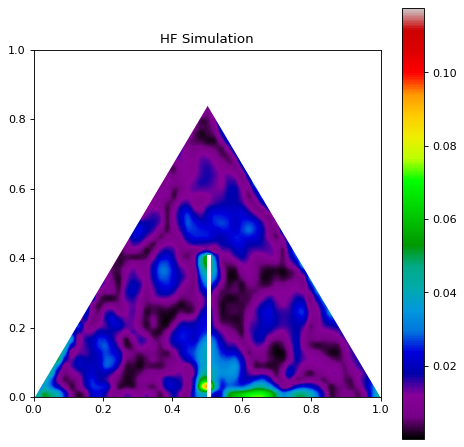

In [ ]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 17

fig1 = plt.figure(figsize=(7,7), dpi=80)
plt.imshow(abs_error[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral')
plt.title('HF Simulation')

xf = np.array([0., xmax/2]); yf = xf*(ymax/(xmax/2)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([xmax/2, xmax]); yf = (xf-xmax)*(ymax/((xmax/2)-xmax)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([0, xmax]); plt.fill_between(xf, ymax, s_disp, color = [1, 1, 1])
plt.gca().add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))

plt.colorbar()

In [ ]:
np.mean(abs_error[value,:,:])

0.012843354

In [ ]:
np.mean(y_test[value,:,:])

0.09982116